In [1]:
from pyoxigraph import *
from RDF import RDF
from OWL import OWL
from RDFS import RDFS
from utils import *
from Ressources import *
from Ontology import *

/home/kipp_sa/github/EmbedAlign/embed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.cuda.is_available()
print(device)

True


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Example: embeddings tensor (N_samples x D)
# embeddings = torch.randn(50, 768, device='cuda')  # optionally on GPU



def plot_region(mu_2d, cov_2d, label=None, n_std=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    width, height, angle = covariance_to_ellipse_params(cov_2d, n_std)
    ellipse = Ellipse(
        xy=mu_2d.cpu().numpy(),
        width=width,
        height=height,
        angle=angle,
        edgecolor='blue',
        facecolor='lightblue',
        alpha=0.4
    )
    ax.add_patch(ellipse)
    ax.scatter(mu_2d[0].cpu().numpy(), mu_2d[1].cpu().numpy(), c='red', s=30)
    if label:
        ax.text(mu_2d[0].cpu().numpy(), mu_2d[1].cpu().numpy(), f" {label}", fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    return ax

In [4]:
file = "../test/bfo-core.ttl"
bfo = Ontology.load(file)

In [5]:
for c in bfo.restrictions:
    print(c)

(has temporal part ONLY zero-dimensional temporal region)
(has continuant part ONLY fiat point)
(has continuant part ONLY continuant fiat boundary)
(has continuant part ONLY (fiat line OR fiat point))
(has continuant part ONLY continuant fiat boundary)
(location of ONLY continuant fiat boundary)
(has continuant part ONLY (site OR material entity OR continuant fiat boundary))
(continuant part of ONLY material entity)
(temporal part of ONLY one-dimensional temporal region)
(has temporal part ONLY (one-dimensional temporal region OR zero-dimensional temporal region))
(temporal part of ONLY (process OR process boundary))
(occurrent part of ONLY (process OR process boundary))
(has temporal part ONLY process boundary)
(has occurrent part ONLY process boundary)
(occupies spatial region ONLY three-dimensional spatial region)
(has continuant part ONLY (site OR continuant fiat boundary))
(continuant part of ONLY (site OR material entity))
(has continuant part ONLY spatial region)
(has continuant

In [6]:
for c in bfo.classes:
    print(c)

temporal instant
temporal interval
history
zero-dimensional temporal region
fiat point
fiat surface
relational quality
(fiat line OR fiat point)
fiat line
immaterial entity
continuant fiat boundary
(site OR material entity OR continuant fiat boundary)
material entity
(one-dimensional temporal region OR zero-dimensional temporal region)
one-dimensional temporal region
(process OR process boundary)
(process OR process boundary)
process boundary
function
generically dependent continuant
object
(site OR continuant fiat boundary)
(site OR material entity)
site
three-dimensional spatial region
object aggregate
(zero-dimensional spatial region OR one-dimensional spatial region)
one-dimensional spatial region
fiat object part
role
specifically dependent continuant
quality
zero-dimensional spatial region
realizable entity
disposition
(process OR process boundary)
process
spatiotemporal region
(two-dimensional spatial region OR zero-dimensional spatial region OR one-dimensional spatial region)
t

temporal instant has center tensor([ 1.2292, -1.0167]) and covariance tensor([[4.9483e+01, 2.9206e-06],
        [2.0564e-06, 1.9158e+01]])
temporal interval has center tensor([ 1.7664, -0.8316]) and covariance tensor([[ 3.7656e+01, -2.6524e-06],
        [-2.8759e-06,  1.4248e+01]])
history has center tensor([ 3.6987, -0.3446]) and covariance tensor([[ 4.3499e+01, -6.0797e-06],
        [-5.7220e-06,  1.9264e+01]])
zero-dimensional temporal region has center tensor([-0.4946, -0.0005]) and covariance tensor([[2.2523e+01, 3.5241e-06],
        [3.1441e-06, 1.0118e+01]])
fiat point has center tensor([1.9151, 0.7385]) and covariance tensor([[5.6047e+01, 2.3842e-07],
        [2.9802e-08, 2.0438e+01]])
fiat surface has center tensor([ 1.9072, -0.0195]) and covariance tensor([[5.3240e+01, 2.7418e-06],
        [1.8775e-06, 2.7803e+01]])
relational quality has center tensor([ 1.2663, -0.4906]) and covariance tensor([[ 5.3081e+01,  3.4273e-07],
        [-2.3097e-07,  2.1636e+01]])
fiat line has cen

[]

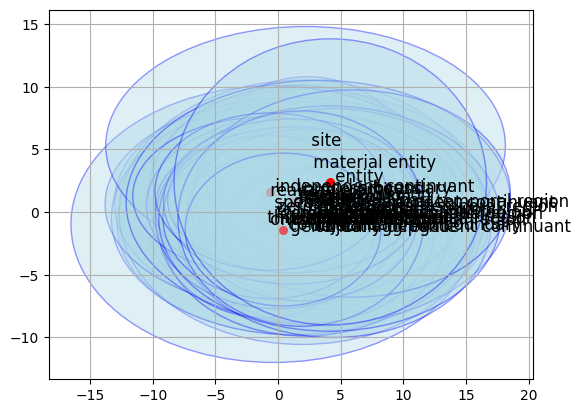

In [7]:

figs, axs = plt.subplots()
for c in bfo.named_classes:
    center, cov = c.get_initial_region()
    print(f"{c} has center {center} and covariance {cov}")
    plot_region(center, cov, label=str(c), n_std=2.0, ax=axs)
plt.plot()

In [13]:
word_1 = "bank"
sentences = ["I have 200 dollars in my bank account", 
            "My bank is on 35th street", 
            "I took out a lone at my bank",
            "my bank is closed on weekends"]
sentences_2 = ["the ship is at the river bank", 
            "the river bank is muddy", 
            "I like sitting at bank of the river",
            "the river bank can not close"]

## OAS

In [43]:
from sklearn.covariance import OAS
import numpy as np

    

def oas(word, sentences):
    embeddings = [embed_label(word, s) for s in sentences]
    stacked = torch.stack(embeddings)
    data = np.array(embeddings)
    oas = OAS()
    return stacked, oas.fit(data)

def fit_pca(oas : OAS):
    var = oas.covariance_
    var_t = torch.from_numpy(var).float()
    M, D, V = torch.linalg.svd(var_t)
    return V[:2].T.cpu().numpy()

def project_mean_and_cov(mu: torch.Tensor, cov: torch.Tensor, W: torch.Tensor):
    mu_2d = W.T @ mu
    cov_2d = W.T @ cov @ W
    return mu_2d, cov_2d

def get_ellipsis(word : str, sentences : list):
    embeddings, oac = oas(word, sentences)
    mean = embeddings.mean(dim=0).cpu().numpy()
    pca = fit_pca(oac)
    print(type(pca))
    return project_mean_and_cov(mean, oac.covariance_, pca)

In [51]:
def covariance_to_ellipse_params(cov_2d: torch.Tensor, n_std=1.0):
    eigvals, eigvecs = torch.linalg.eigh(cov_2d)
    idx = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    width, height = 2 * n_std * torch.sqrt(eigvals)
    angle = torch.atan2(eigvecs[1, 0], eigvecs[0, 0]) * (180.0 / torch.pi)
    return width.item(), height.item(), angle.item()


def plot_region_2(mu_2d, cov_2d, label=None, n_std=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    width, height, angle = covariance_to_ellipse_params(torch.from_numpy(cov_2d), n_std)
    ellipse = Ellipse(
        xy=mu_2d,
        width=width,
        height=height,
        angle=angle,
        edgecolor='blue',
        facecolor='lightblue',
        alpha=0.4
    )
    ax.add_patch(ellipse)
    ax.scatter(mu_2d[0], mu_2d[1], c='red', s=30)
    if label:
        ax.text(mu_2d[0], mu_2d[1], f" {label}", fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    return ax

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[]

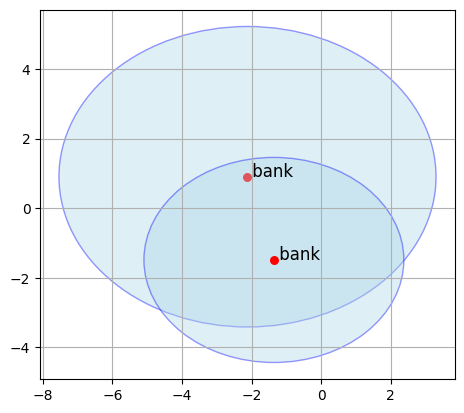

In [52]:
mu1, cov1 = get_ellipsis(word_1, sentences)
mu2, cov2 = get_ellipsis(word_1, sentences_2)

figs, axs = plt.subplots()

plot_region_2(mu1, cov1, label=word_1, n_std=2.0, ax=axs)
plot_region_2(mu2, cov2, label=word_1, n_std=2.0, ax=axs)
plt.plot()